In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import glob, os, pickle, json

""" Source name in order to just complete the results file, and
in order to improve run organization."""
source_name = "crab"

# Root path of this script
root = os.getcwd() + "/"
# Path to store objects
root_objects = root + f"objects/"
# Data main directory
root_data = root + f"../../data/cherenkov_transparency_corrections/{source_name}/"
# Directory for the results of the fit of each run
root_results = root_objects + "results_fits/"
root_final_results = root_objects + "final_results_fits/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy import optimize
import subprocess

from astropy.coordinates     import SkyCoord
from lstchain.io.config      import get_standard_config
from ctapipe.io              import read_table
import tables

# Other auxiliar scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import geometry as geom
import lstpipeline
import plotting

import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)
""" Source name in order to just complete the results file, and
in order to improve run organization."""
source_name = "crab"

""" Fit parameters
Chosen limits in intensity (p.e.) for applying the fit i.e. the
power law will be fitted only with the points within this range."""
limits_intensity = [316, 562]
""" For the positive scaling cases (most of them), we need to have a lower 
limit in intensity. Thi slimit is used for the subset of events that are 
scaled just to find which is the scaling value. We use a very low limit by
default 60 p.e. compared to the lower limit of the fit 316 p.e. because in 
the worst cases we will have a very non-linear scaling that will displace 
significantly the events intensities."""
limits_intensity_extended = 60

""" Power law parameters for the reference
All these parameters are taken from a common analysis of the full dataset
Where the period of end of 2022 and start 2023 is taken as reference for good 
runs. Then we take as reference the mean power law parameters in that period.
p0 is the normalization factor and p1 is the slope."""
ref_p0 =  1.74 
ref_p1 = -2.23

""" Threshold in statistics for the last subrun
The limit in number of events after cleaning that we need to consider the last
subrun has enough statistics to perform the analysis over it. Otherwise the 
values of the scaling that will be applied to this last rubrun are the same 
that are applied to the last last subrun."""
statistics_threshold = 15000

""" Parameters for the empyrical fits for Zenith Distance corrections
Are simply two 2 degree polynomials for each variable of the power law."""
p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068

# Standard paths for data in the IT cluster ---------
root_dl1 = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
# root_rfs = "/fefs/aswg/data/models/AllSky/20240131_allsky_v0.10.5_all_dec_base/"
root_rfs = "/fefs/aswg/data/models/AllSky/20230927_v0.10.4_crab_tuned/"
# root_mcs = "/fefs/aswg/data/mc/DL2/AllSky/20240131_allsky_v0.10.5_all_dec_base/TestingDataset/"
root_mcs = "/fefs/aswg/data/mc/DL2/AllSky/20230927_v0.10.4_crab_tuned/TestingDataset/"

# Root path of this script
root = os.getcwd() + "/"
# Path to store the configuration file we are going to use
config_file = root + "config/standard_config.json"
# Path to store objects
root_objects = root + f"objects/"
# Data main directory
root_data = root + f"../../data/cherenkov_transparency_corrections/{source_name}/"
# Sub-dl1 objects directory
root_sub_dl1 = root_objects + "sub_dl1/"
# Directory for the results of the fit of each run
root_results = root_objects + "results_fits/"
root_final_results = root_objects + "final_results_fits/"
# Slurm output folder
root_slurm = root + "objects/output_slurm"
# Configuration file for the job launching
file_job_config = root_objects + "config/job_config_runs.txt"

def configure_lstchain():
    """Creates a file of standard configuration for the lstchain analysis. 
    It can be changed inside this function"""
    dict_config = get_standard_config()
    # We select the heuristic flatfield option in the standard configuration
    dict_config["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True
    with open(config_file, "w") as json_file:
        json.dump(dict_config, json_file)


Adding dl1  data to dictionary (Run 3271)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 3271)...
...Finished adding dl1 data to dictionary


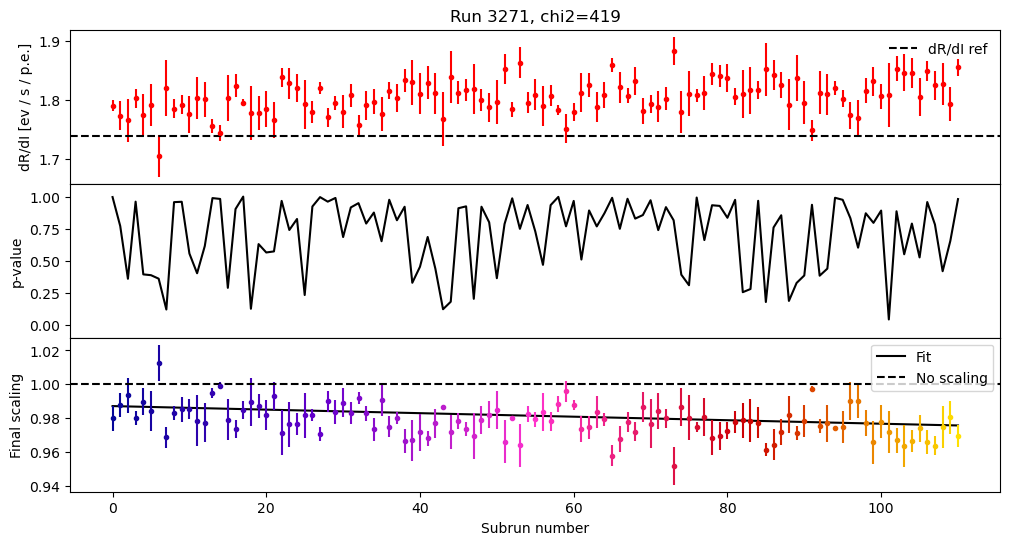

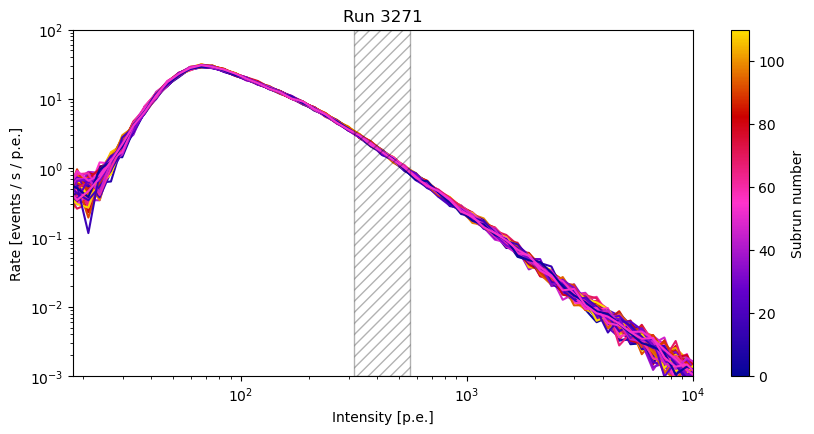


Adding dl1  data to dictionary (Run 3373)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 3373)...
...Finished adding dl1 data to dictionary


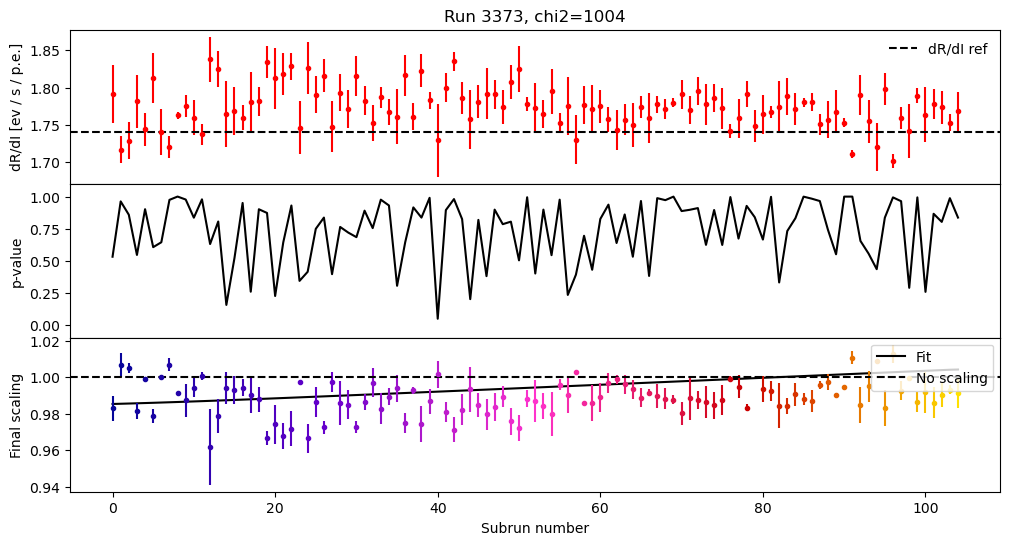

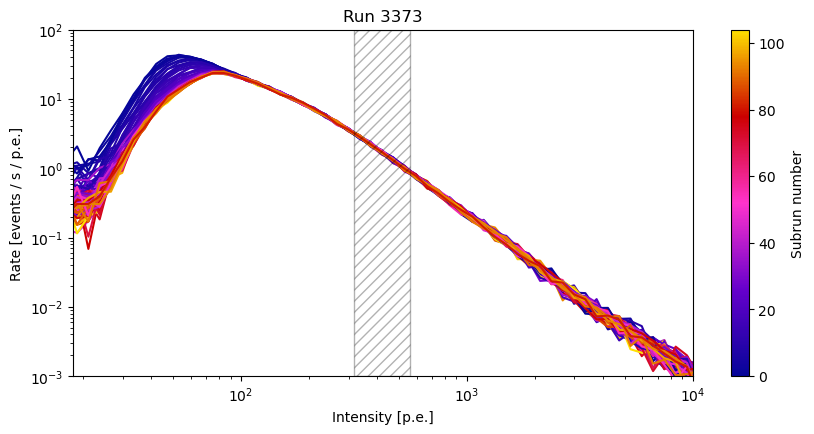


Adding dl1  data to dictionary (Run 2975)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 2975)...
...Finished adding dl1 data to dictionary


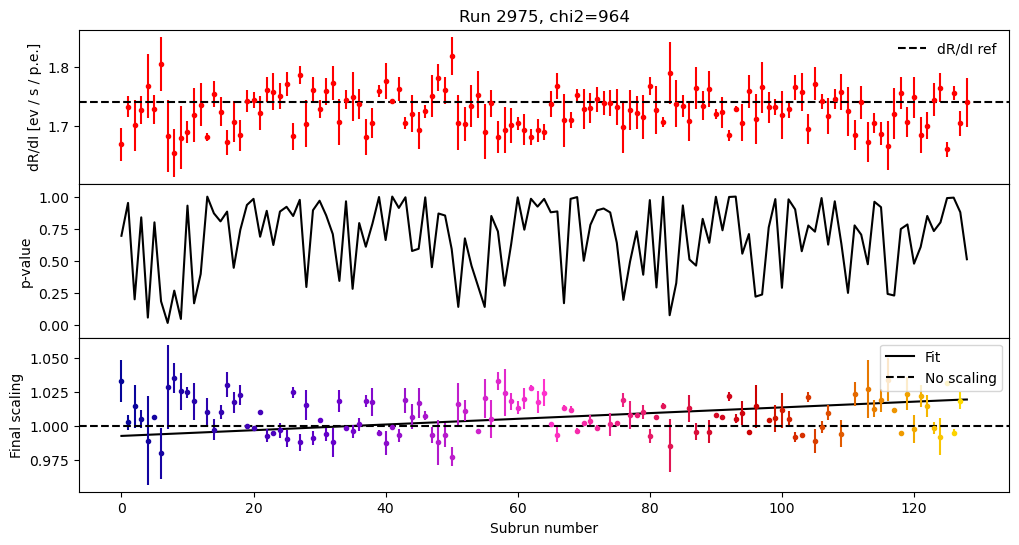

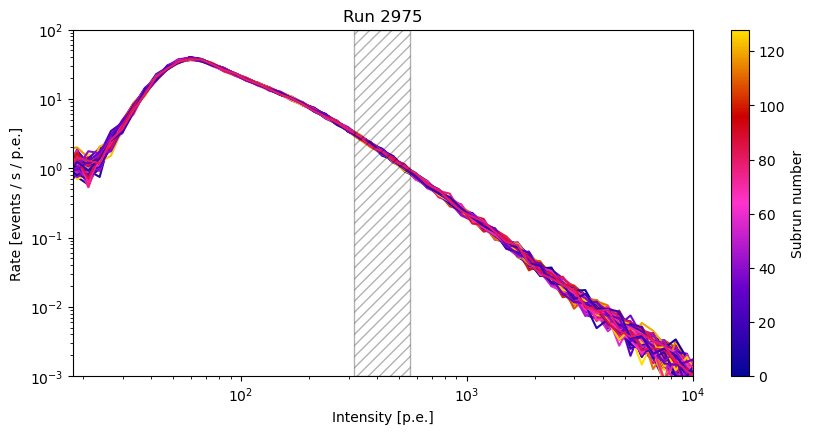


Adding dl1  data to dictionary (Run 2972)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 2972)...
...Finished adding dl1 data to dictionary


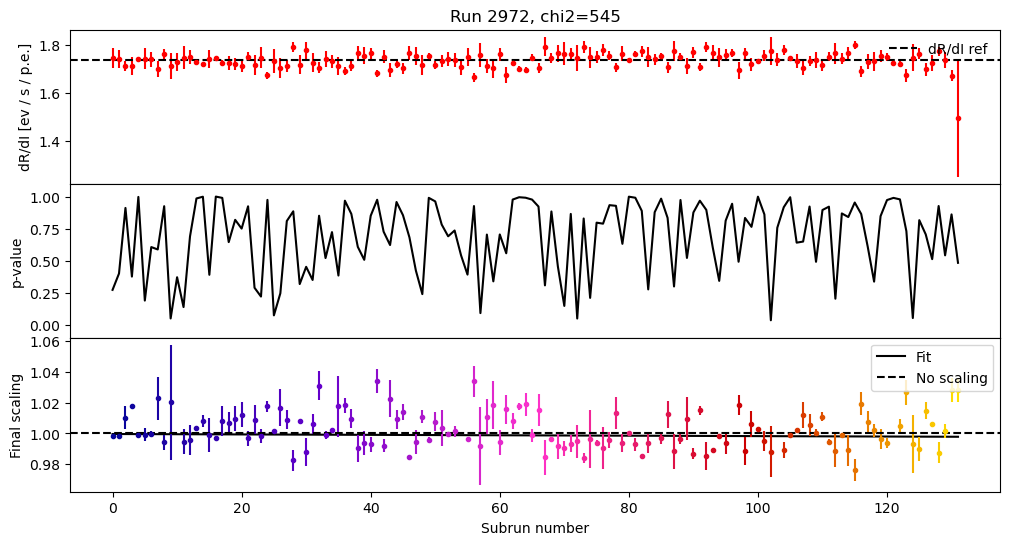

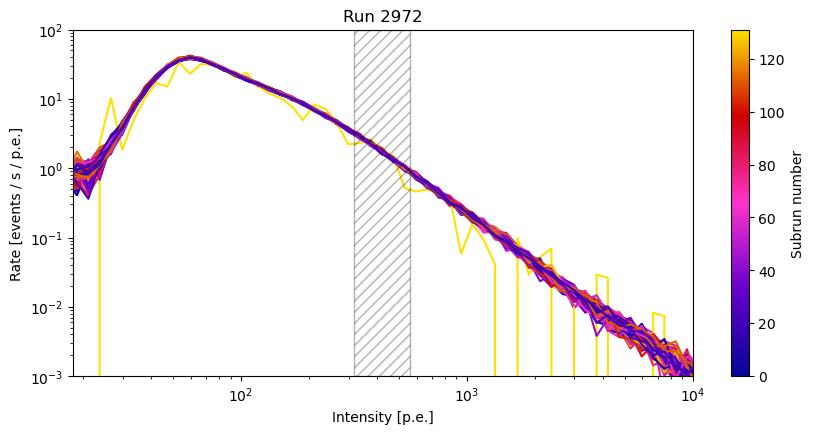


Adding dl1  data to dictionary (Run 2914)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 2914)...
...Finished adding dl1 data to dictionary


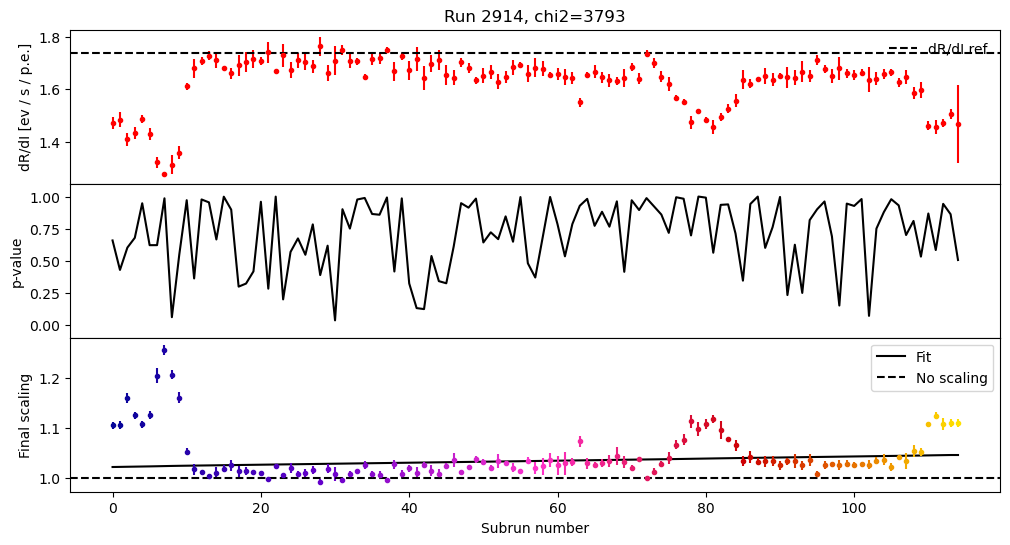

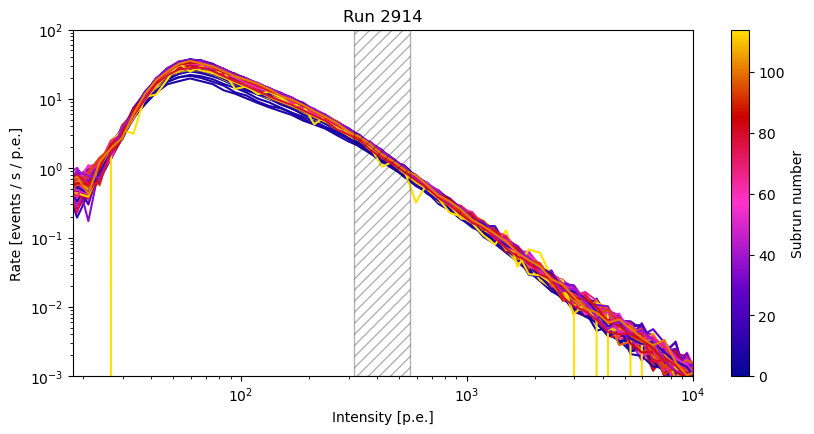


Adding dl1  data to dictionary (Run 2933)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 2933)...
...Finished adding dl1 data to dictionary


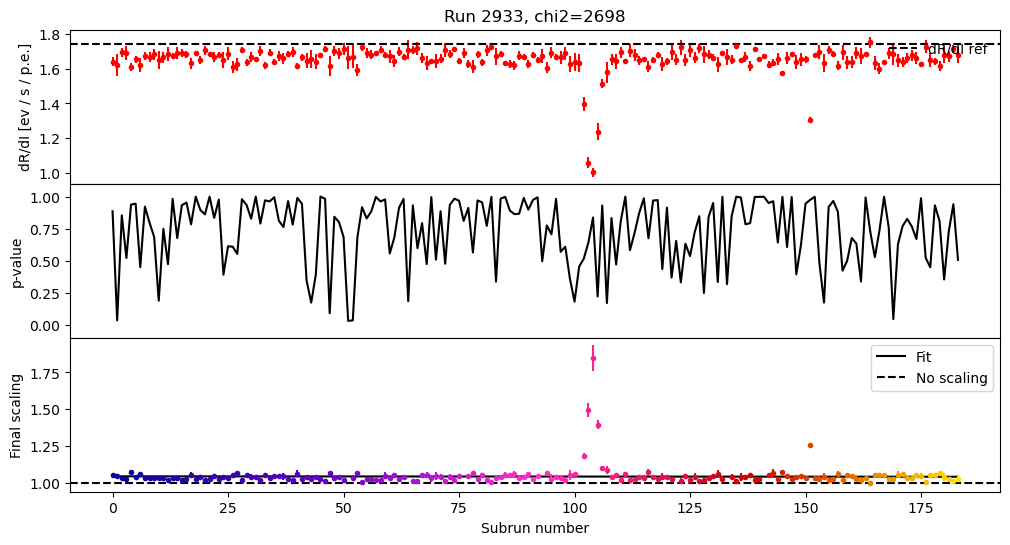

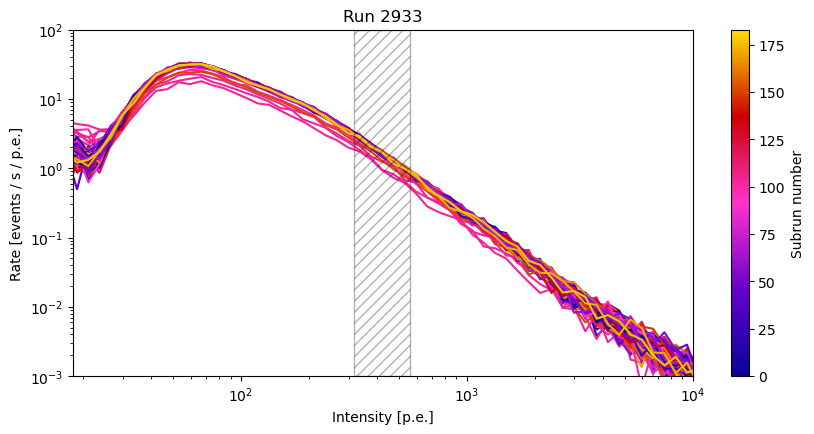


Adding dl1  data to dictionary (Run 3319)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 3319)...
...Finished adding dl1 data to dictionary


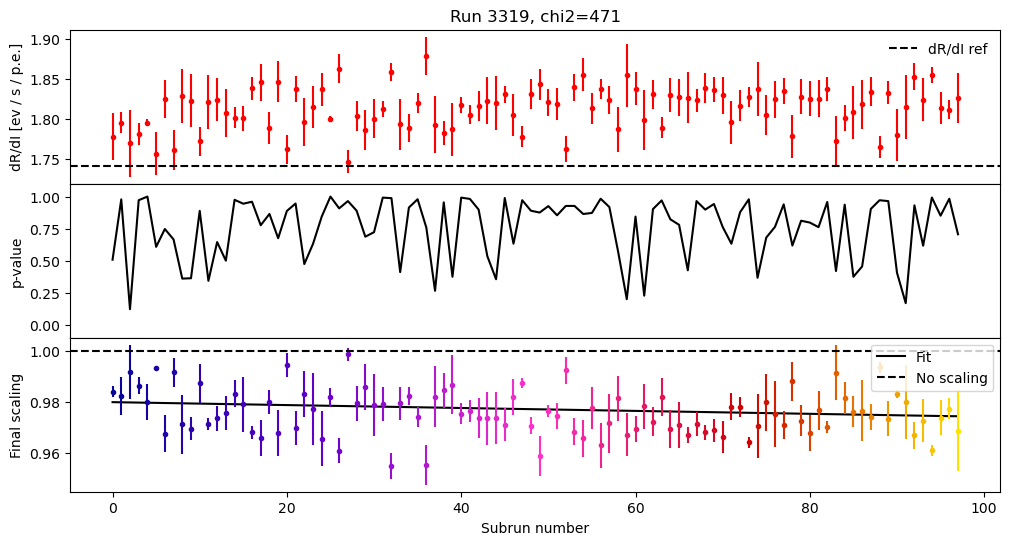

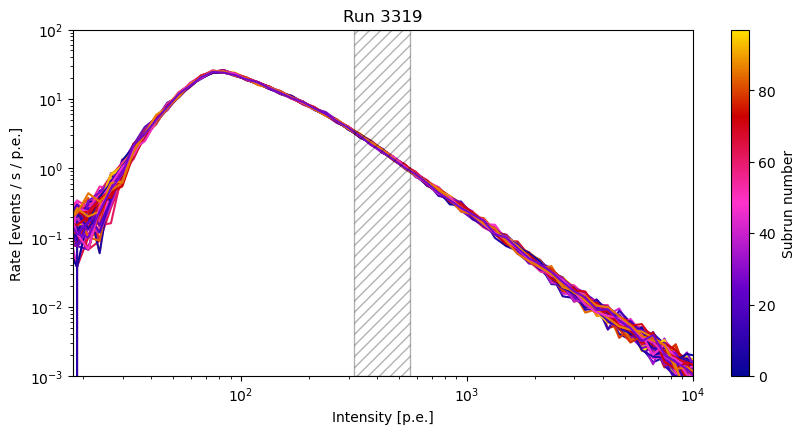


Adding dl1  data to dictionary (Run 2949)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 2949)...
...Finished adding dl1 data to dictionary


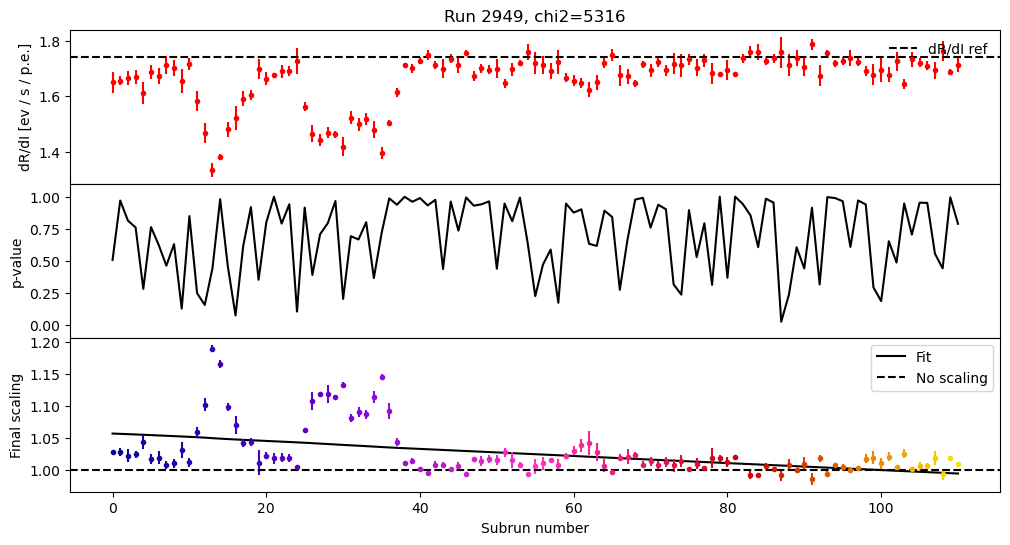

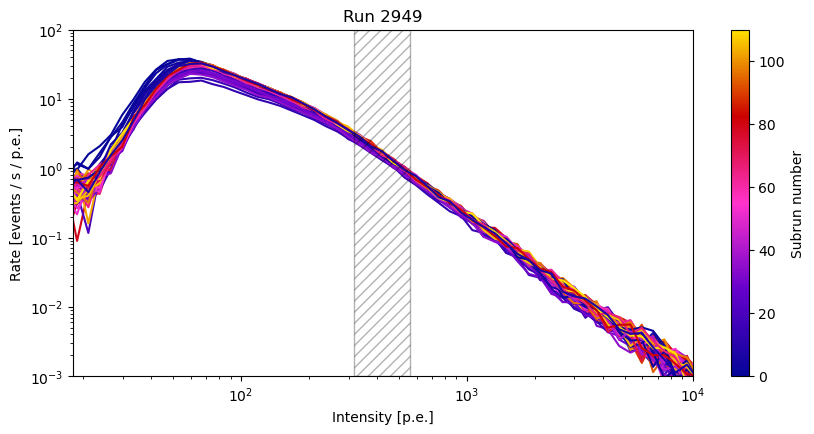


Adding dl1  data to dictionary (Run 3094)...
...Finished adding dl1 data to dictionary


In [ ]:
aa = glob.glob(root_final_results + "*")
dict_general_results = {}
all_values_scaling = []

for i in range(len(aa))[:]:
    a = aa[i]

    with open(a, 'rb') as f:
        _dict_results_ = pickle.load(f)
    
    run = int(a.split("/")[-1].split("_")[-1].split(".")[0])
    run_number = run


    # Getting coordinates of source
    source_coords = SkyCoord.from_name(source_name)
    
    dict_source = {
        "name"   : source_name,
        "coords" : source_coords,
        "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
        "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
    }
    
    # We create a empty dictionary to store all the information needed inside
    dict_dchecks = {}
    for run in [run_number]:
        dict_dchecks[run] = {
            "run_num" : run,
        }
    # Then we add the paths to the files and the datachecks
    dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1)
    dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1, dchecking=True)


    dcheck_zd, dcheck_az = [], []
    dcheck_tstart, dcheck_telapsed = [], []
    
    for srun in range(len(dict_dchecks[run_number]["dchecks"]["srunwise"])):
        tab_dcheck_srun = read_table(dict_dchecks[run_number]["dchecks"]["srunwise"][srun], "/dl1datacheck/cosmics")
        
        # reading the variables
        dcheck_zd.append(90 - np.rad2deg(tab_dcheck_srun["mean_alt_tel"]))
        dcheck_az.append(np.rad2deg(tab_dcheck_srun["mean_az_tel"]))
        
        dcheck_tstart.append(tab_dcheck_srun["dragon_time"])
        dcheck_telapsed.append(tab_dcheck_srun["elapsed_time"])
    
    dcheck_zd = np.array(dcheck_zd)
    dcheck_az = np.array(dcheck_az)
    dcheck_tstart = np.array(dcheck_tstart)
    dcheck_telapsed = np.array(dcheck_telapsed)
    
    dict_dchecks[run_number]["time"] = {
        "tstart"   : dcheck_tstart[0],            # datetime object
        "telapsed" : np.sum(dcheck_telapsed),  # s
        "srunwise" : {
            "telapsed" : dcheck_telapsed,      # s      
        },
    }
    dict_dchecks[run_number]["pointing"] = {
        "zd" : np.mean(dcheck_zd),  # deg
        "az" : np.mean(dcheck_az),  # deg
        "srunwise" : {
            "zd" : dcheck_zd, # deg
            "az" : dcheck_az, # deg
        },
    }
    # then we also select the RFs and MC files looking at the nodes available
    dict_dchecks, dict_nodes = lstpipeline.add_mc_and_rfs_nodes(dict_dchecks, root_rfs, root_mcs, dict_source)


    # Pivot intensity for decorrelation
    ref_intensity = (limits_intensity[0] * limits_intensity[1]) ** 0.5
    
    ########################################################
    # Reading the binning from the datacheck ---------------
    # Opening the corresponding datacheck
    fname_dcheck = dict_dchecks[run_number]["dchecks"]["runwise"]
    tab_dcheck_run = tables.open_file(fname_dcheck)
    
    # Read the binning from the datacheck of the first subrun
    dcheck_intensity_binning = np.array(tab_dcheck_run.root.dl1datacheck.histogram_binning.col("hist_intensity")[0])
    # Calculating the logarithmic center of each bin
    dcheck_intensity_binning_centers = (dcheck_intensity_binning[:-1] * dcheck_intensity_binning[1:]) ** 0.5
    # Calculating the width of each bin
    dcheck_intensity_binning_widths = np.diff(dcheck_intensity_binning)
    tab_dcheck_run.close()
    
    # Mask for the fitting region in the fits
    mask_dcheck_bins_fit = (
        (dcheck_intensity_binning_centers >= limits_intensity[0]) &
        (dcheck_intensity_binning_centers <= limits_intensity[1])
    )

    ##########################################################
    # Reading the histogram from the datacheck ---------------
    # Opening the corresponding datacheck
    dcheck_hist_intensities = []
    for fname_dcheck_srun in dict_dchecks[run_number]["dchecks"]["srunwise"]:
        tab_dcheck_srun = tables.open_file(fname_dcheck_srun)
        dcheck_hist_intensities.append(np.array(tab_dcheck_srun.root.dl1datacheck.cosmics.col("hist_intensity")))
        tab_dcheck_srun.close()
    
    # Converting from counts to rate per intensity unit (non-binning dependent quantity)
    dcheck_rates       = [] # Array of histogram of rates for each subrun
    dcheck_delta_rates = [] # The statistical error
    for srun, dcheck_hist_intensity in enumerate(dcheck_hist_intensities):
    
        effective_time_srun = dict_dchecks[run_number]["time"]["srunwise"]["telapsed"][srun]
        
        dcheck_rates.append(              dcheck_hist_intensity  / effective_time_srun / dcheck_intensity_binning_widths)
    
        dcheck_delta_rates.append(np.sqrt(dcheck_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths)


    corr_factor_p0 = geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
    corr_factor_p1 = geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p1a, p1b, p1c)
    
    # Zenith correction of the reference (putting the reference in the zenith of the determined subrun)
    corr_ref_p0 = ref_p0 / corr_factor_p0
    corr_ref_p1 = ref_p1 - corr_factor_p1


    
    sruns_array = np.sort(list(_dict_results_["statistics"].keys()))
    
    run_num = _dict_results_["run"]
    a1 = np.array([_dict_results_["final_scaling_interpolated"][srun] for srun in sruns_array])
    a2 = np.array([_dict_results_["final_scaling"][srun] for srun in sruns_array])
    delta_a2 = np.array([_dict_results_["delta_final_scaling"][srun] for srun in sruns_array])
    p0 = np.array([_dict_results_["p0"]["original"][srun] for srun in sruns_array])
    pvalues = np.array([_dict_results_["pvalue"]["original"][srun] for srun in sruns_array])
    delta_p0 = np.array([_dict_results_["delta_p0"]["original"][srun] for srun in sruns_array])
    chi2 = _dict_results_["interpolation"]["chi2"]
    pval = _dict_results_["interpolation"]["p_value"] 
    all_values_scaling = [*all_values_scaling, *a2]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    ax1.errorbar(sruns_array, p0, yerr=delta_p0, ls="", marker=".", c="r")
    ax1.axhline(ref_p0, color="k", ls="--", label="dR/dI ref")
    ax1.set_xlabel("Srun number")
    ax1.set_ylabel("dR/dI [ev / s / p.e.]")
    
    ax2.set_ylabel("p-value")
    ax2.plot(sruns_array, pvalues, c="k")
    ax2.set_ylim(-0.1, 1.1)
    
    ax3.plot(sruns_array, a1, c="k", label="Fit")
    colors = plotting.get_colors_multiplot(sruns_array)
    for i in range(len(sruns_array)):
        ax3.errorbar(sruns_array[i], a2[i], yerr=delta_a2[i], ls="", marker=".", c=colors[i])
    ax3.axhline(1, color="k", ls="--", label="No scaling")
    ax3.set_xlabel("Subrun number")
    ax3.set_ylabel("Final scaling")
    
    ax1.set_title(f"Run {run_num}, chi2={chi2:.0f}")
    ax1.legend(loc=1, frameon=False)
    ax3.legend(loc=1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f"plots/profiles_{run_number}.png", bbox_inches="tight", dpi=300)
    plt.show()
    
    
    bins_space = np.linspace(limits_intensity[0] - 100, limits_intensity[1] + 200, 100)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))
    
    colors = plotting.get_colors_multiplot(sruns_array)
    for i in range(len(dcheck_rates)):
        ax.plot(dcheck_intensity_binning_centers, dcheck_rates[i][0], color=colors[i], zorder=np.random.rand())
    
    cmap = plotting.create_cmap_from_colors(plotting.default_colors)
    plotting.plot_colorbar(fig, ax, range(len(dcheck_rates)), cmap=cmap, label="Subrun number")
    
    intensity_sample = np.linspace(limits_intensity[0] / 1.3, limits_intensity[1] * 1.5, 100)
    ax.axvspan(limits_intensity[0], limits_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k")
    
    ax.set_xlabel("Intensity [p.e.]")
    ax.set_ylabel("Rate [events / s / p.e.]")
    ax.loglog()
    ax.set_xlim(1.8e1, 1e4)
    ax.set_ylim(1e-3, 1e2)
    ax.set_title(f"Run {run_num}")
    
    plt.savefig(f"plots/spectrums_{run_number}.png", bbox_inches="tight", dpi=300)
    plt.show()

all_values_scaling = np.array(all_values_scaling)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist((all_values_scaling-1) * 100, bins=np.linspace(-10, 18, 70), color="royalblue")

ax.axvline(0, color="k", ls="--")
ax.set_ylabel("Counts")
ax.set_xlabel("Scaling needed %")
plt.show()

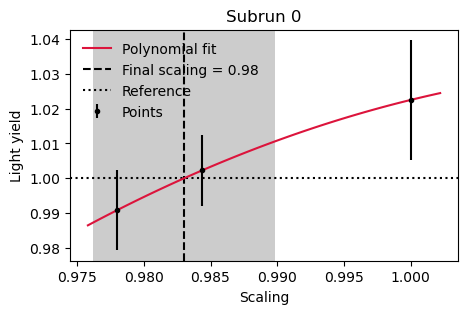

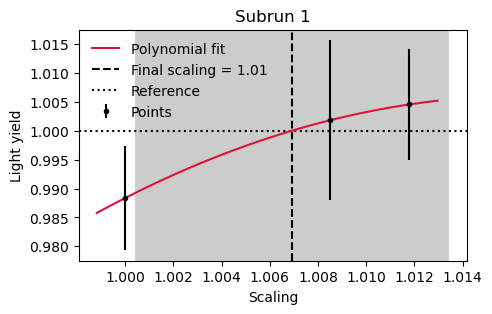

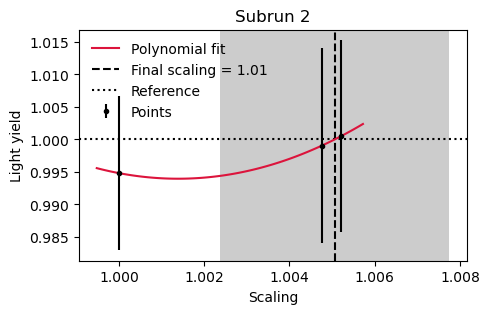

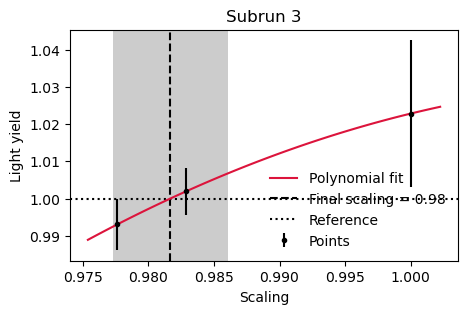

/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing_srunwise/../scripts/geometry.py:292: RuntimeWarning: Mean of empty slice
  delta_x0 = np.nanmean([np.abs(x0-x0M), np.abs(x0-x0m)])


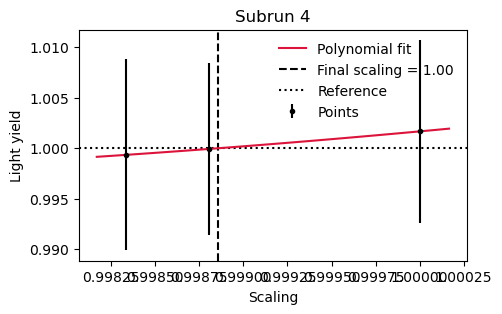

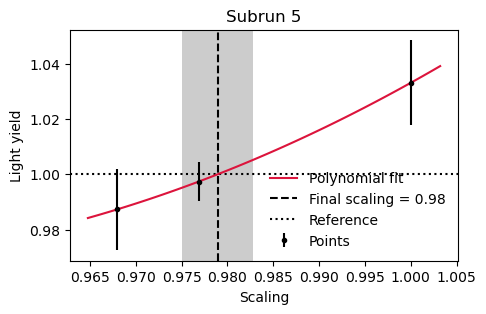

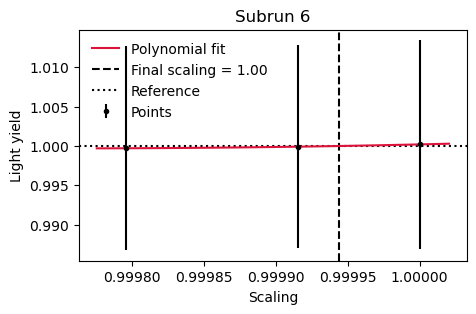

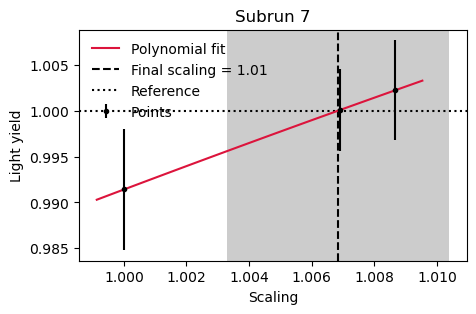

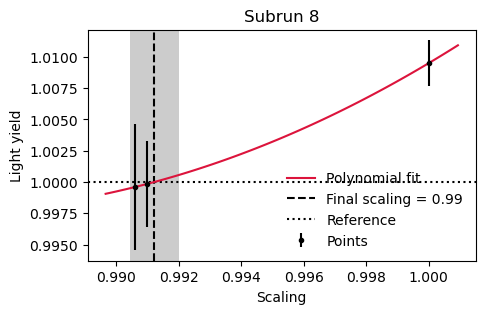

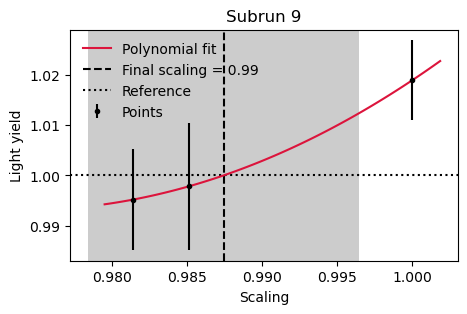

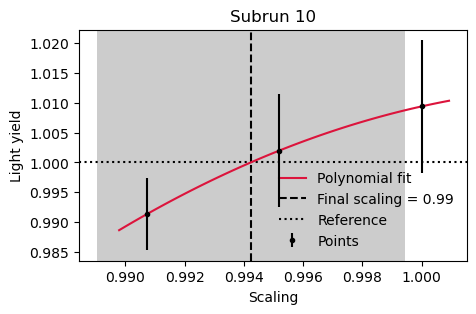

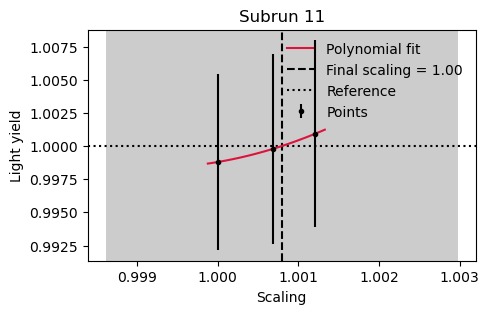

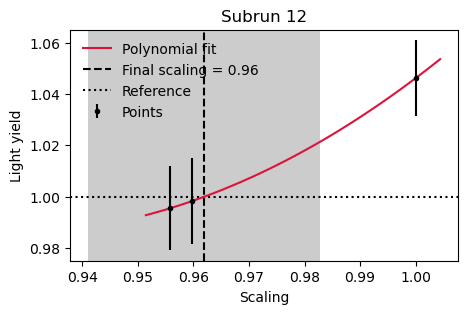

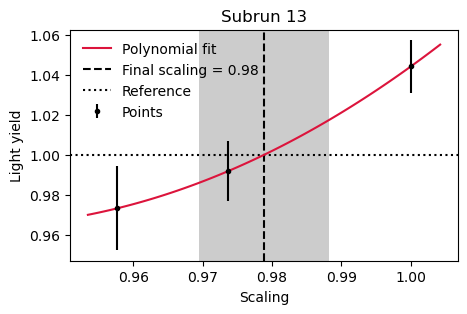

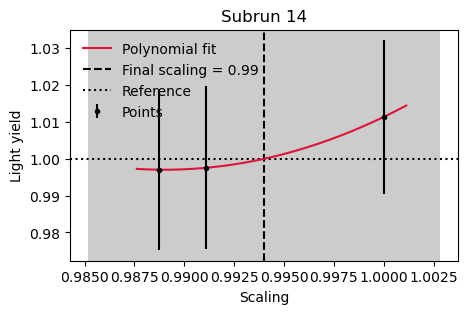

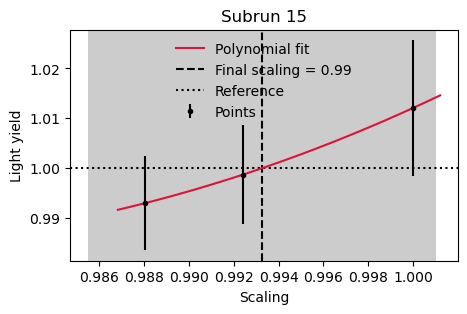

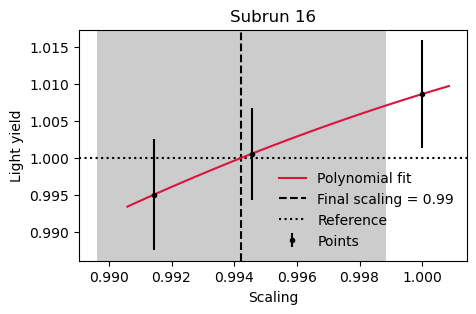

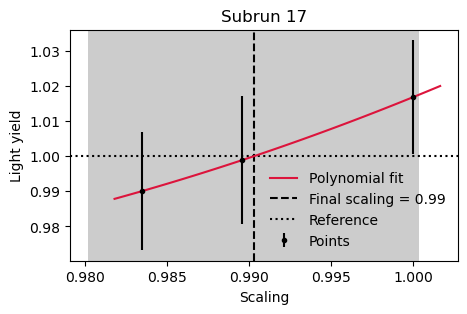

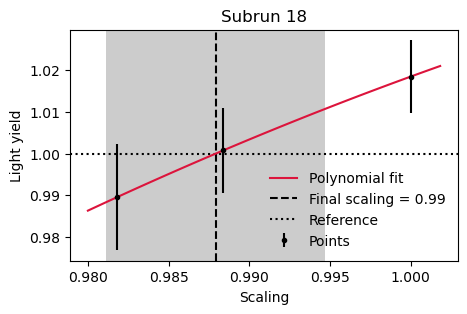

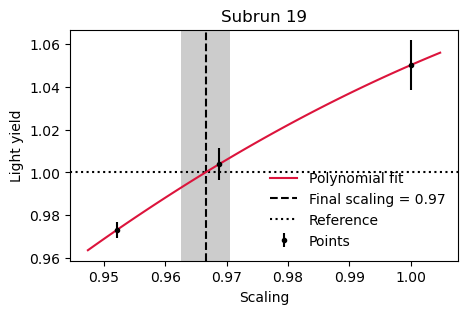

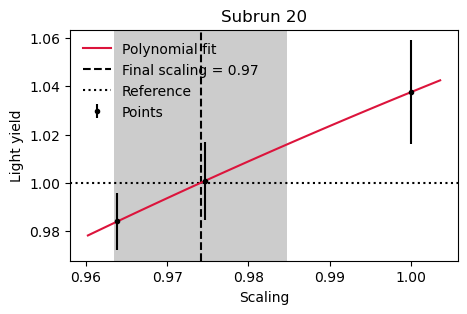

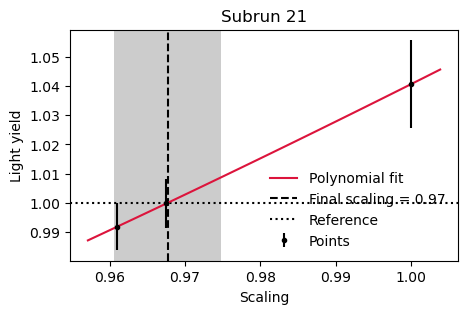

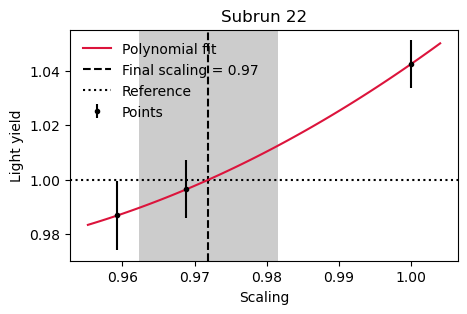

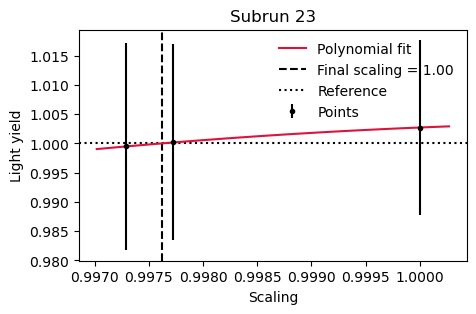

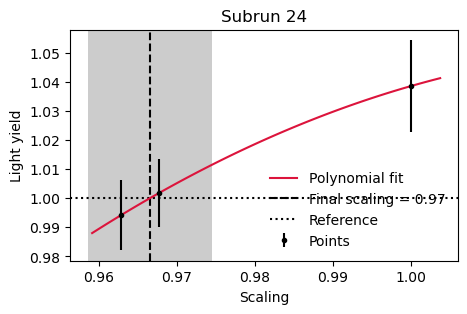

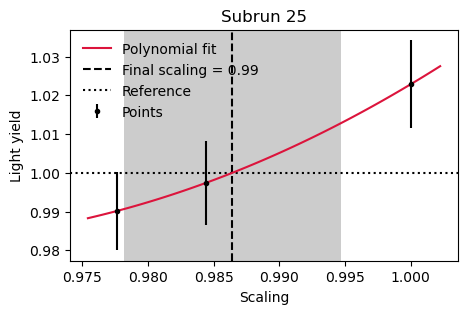

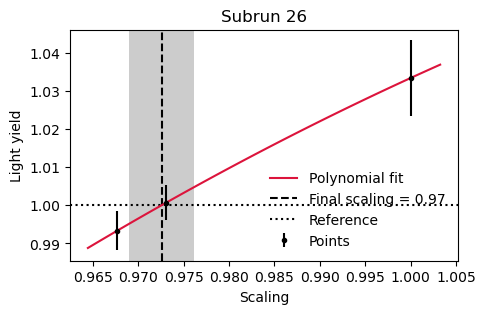

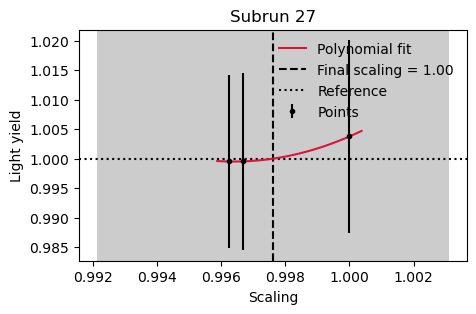

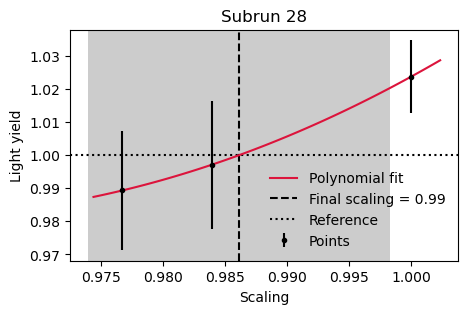

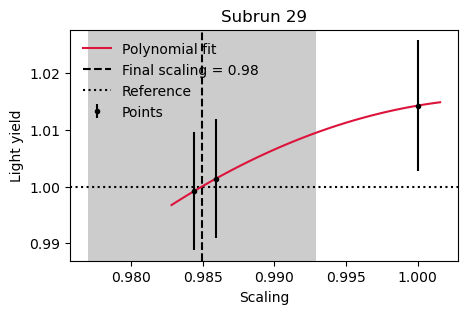

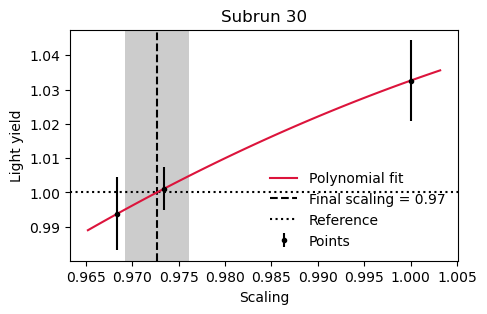

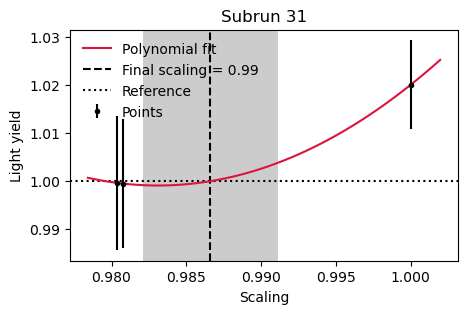

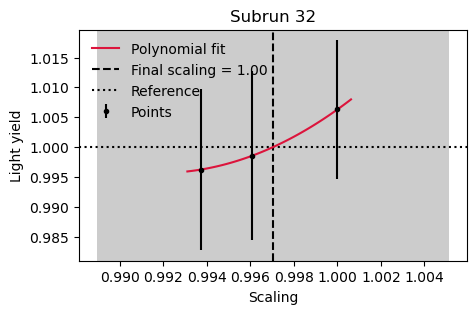

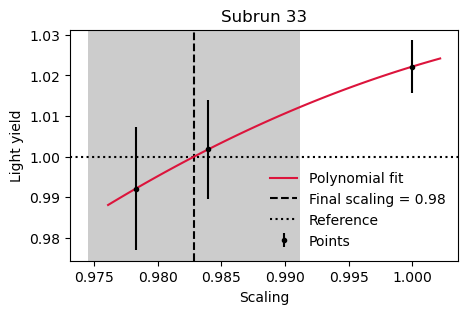

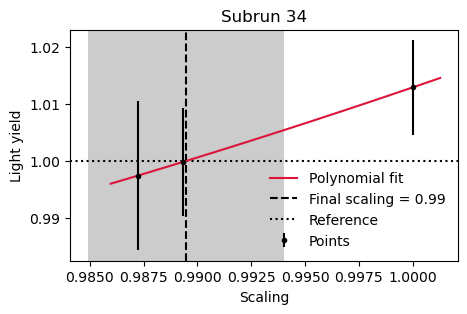

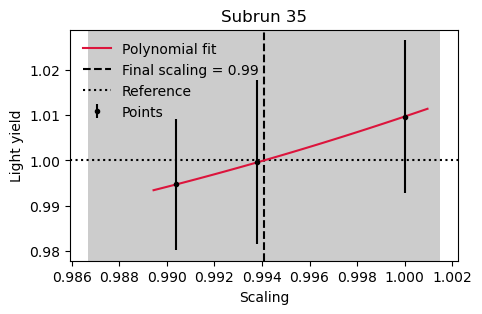

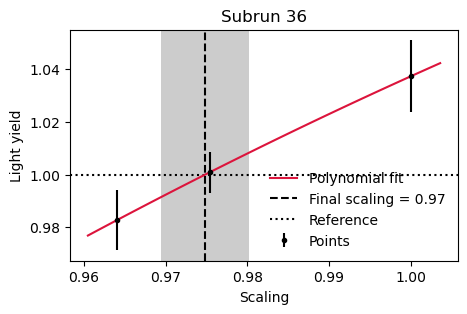

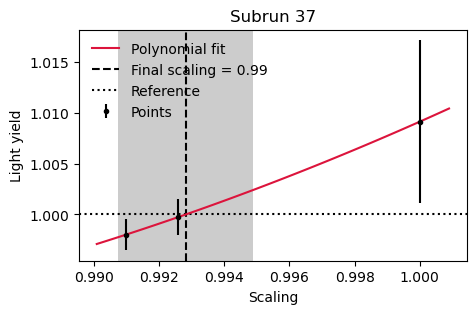

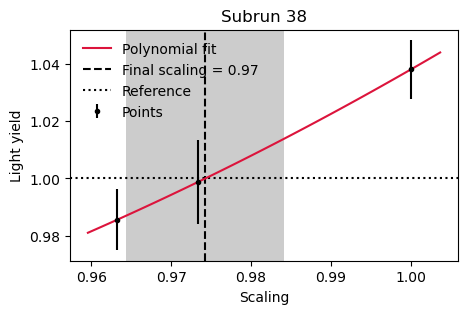

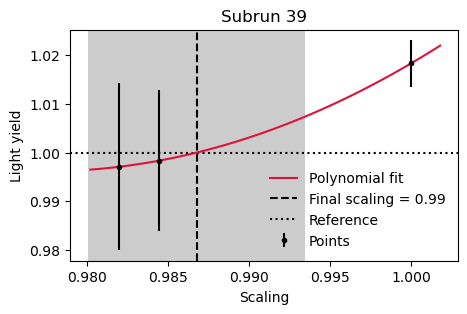

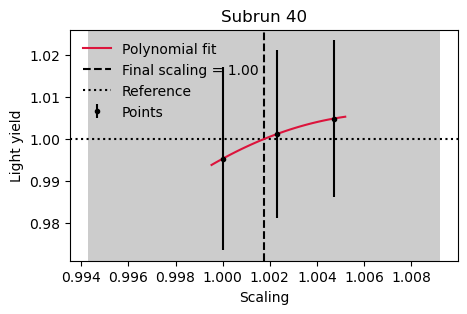

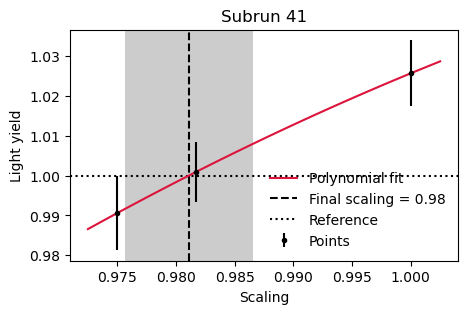

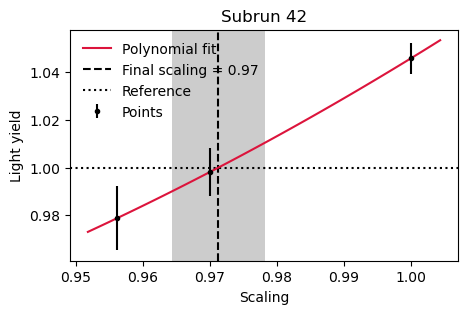

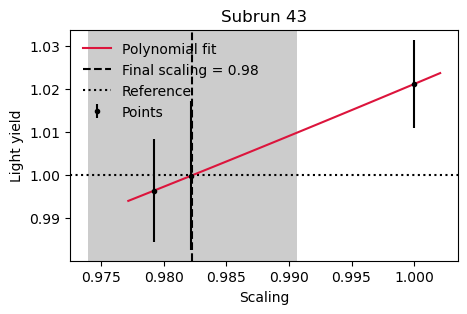

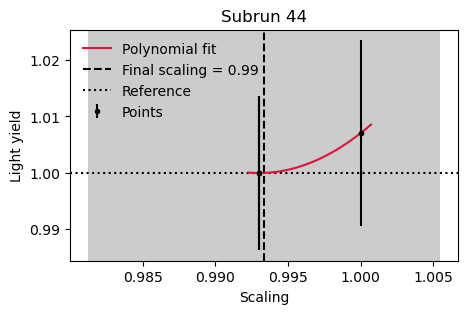

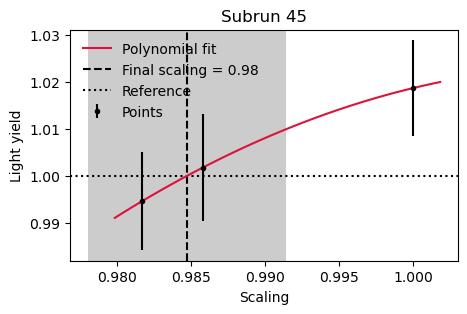

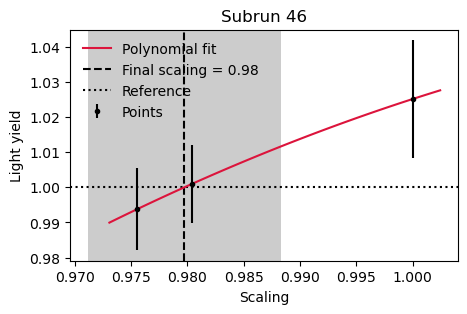

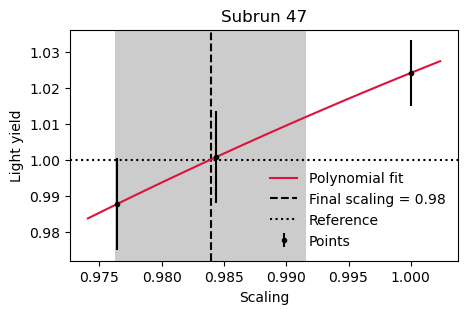

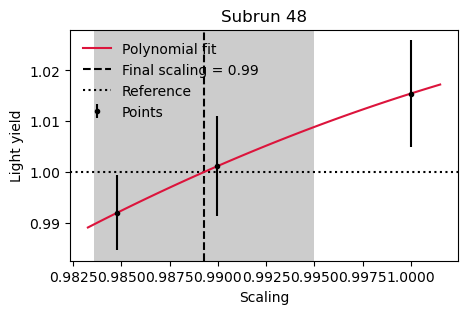

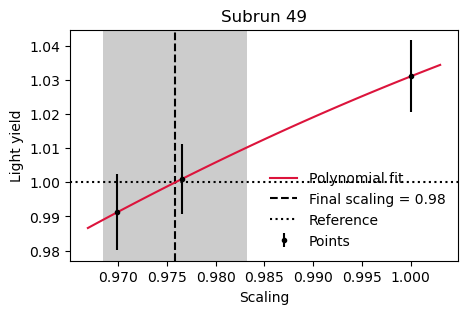

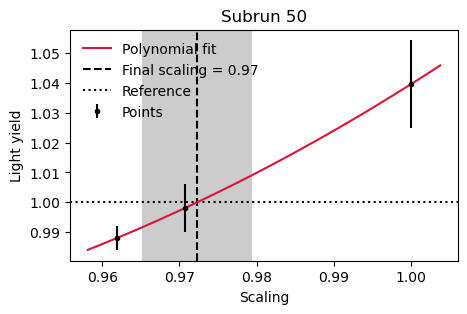

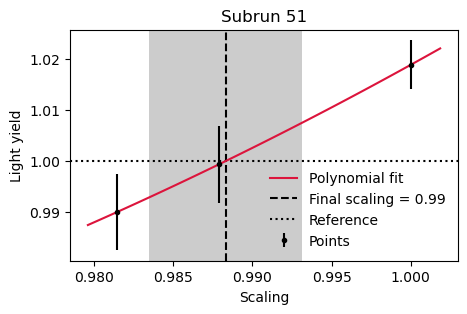

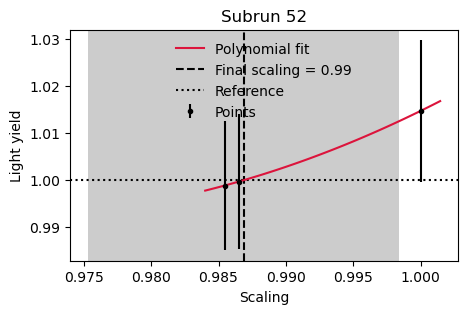

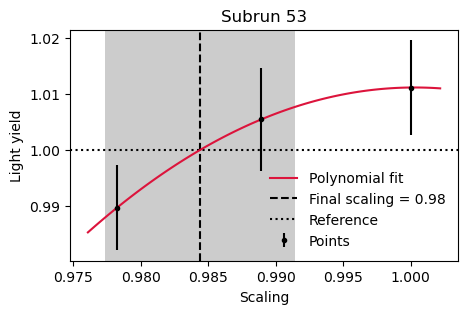

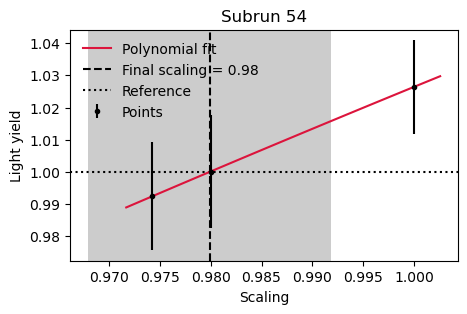

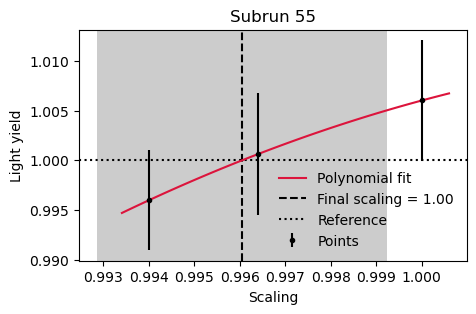

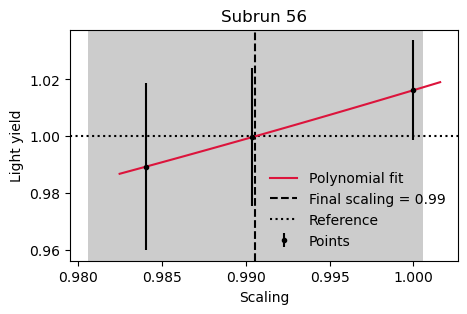

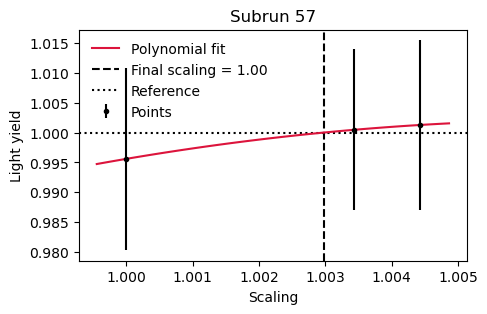

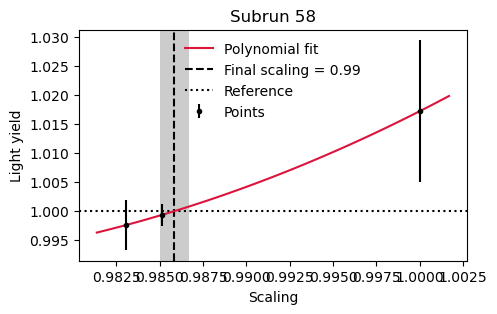

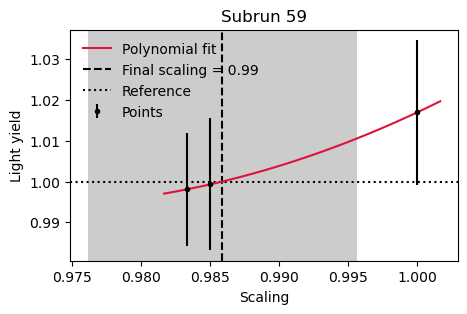

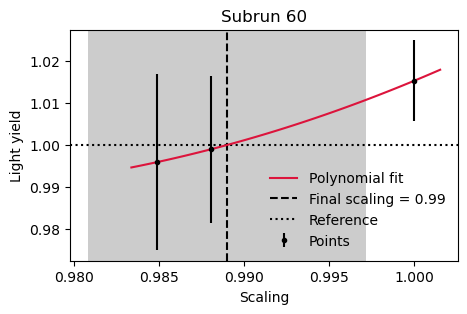

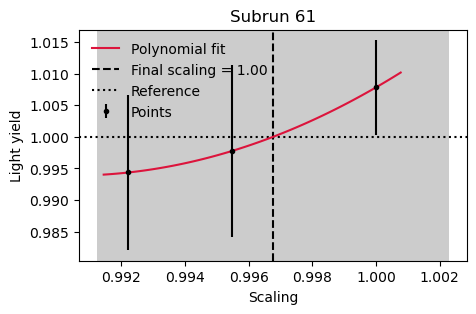

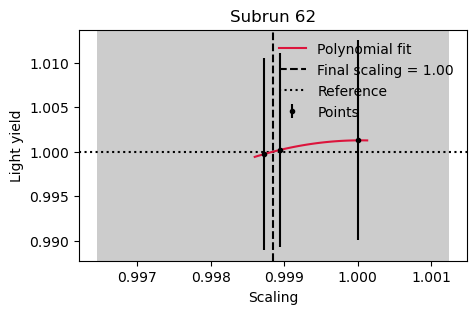

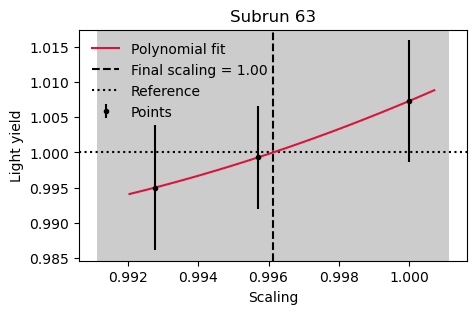

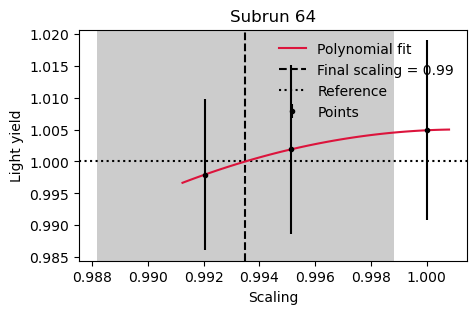

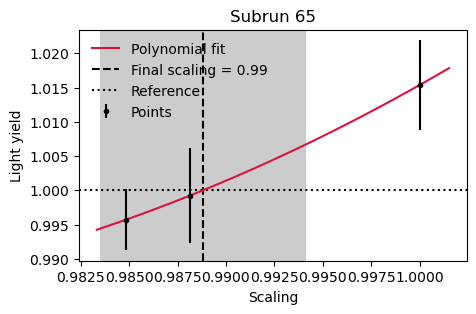

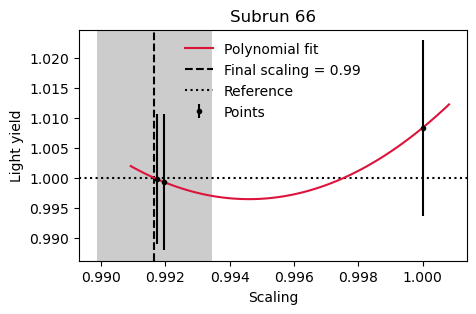

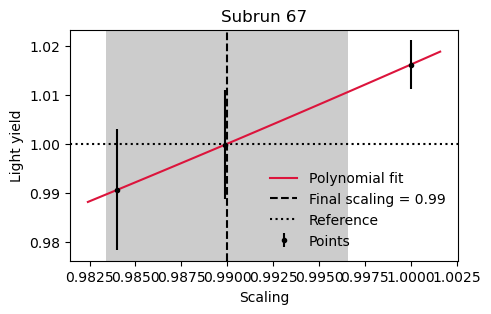

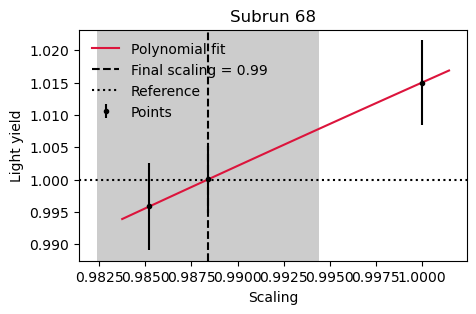

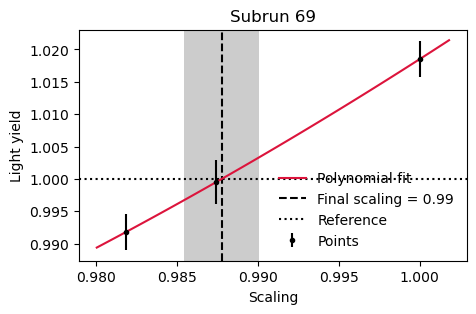

In [6]:
for srun in range(70):

    points_scaling           = np.array([_dict_results_["scaled"][key][srun]            for key in ["original", "linear", "upper"]])
    points_light_yield       = np.array([_dict_results_["light_yield"][key][srun]       for key in ["original", "linear", "upper"]])
    points_delta_light_yield = np.array([_dict_results_["delta_light_yield"][key][srun] for key in ["original", "linear", "upper"]])
    
    srun_a, srun_b, srun_c, srun_delta_a, srun_delta_b, srun_delta_c = geom.parabola_3points(
        *points_scaling, *points_light_yield, *points_delta_light_yield
    )
    
    range_avg_point = np.mean(points_scaling)
    x0, delta_x0 = geom.get_roots_pol2(
        range_avg_point, 1,*points_scaling, *points_light_yield, *points_delta_light_yield
    )

    
    ############################################
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.errorbar(points_scaling, points_light_yield, yerr=points_delta_light_yield,
                marker=".", color="k", label="Points", zorder=10, ls="")
    size_points = max(points_scaling) - min(points_scaling)
    sample_scaling = np.linspace(min(points_scaling) - 0.1 * size_points, max(points_scaling) + 0.1 * size_points, 100)
    ax.plot(sample_scaling, geom.pol2(sample_scaling, srun_a, srun_b, srun_c), 
            color="crimson", ls="-", label="Polynomial fit", zorder=5)
    ax.axvline(x0, color="k", ls="--", label=f"Final scaling = {x0:.2f}")
    ax.axvspan(x0 - delta_x0, x0 + delta_x0, color="k", alpha=0.2, ls="")
    ax.axhline(1, color="k", ls=":", label="Reference")
    ax.set_xlabel("Scaling")
    ax.set_ylabel("Light yield")
    ax.legend(frameon=False)
    ax.set_title(f"Subrun {srun}")
    # plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
    plt.show()
    ############################################

In [36]:
dl2_scaled = "/fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl2_scaled/dl2_LST-1.Run03095.h5"
dl2 = "/fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl2/dl2_LST-1.Run03095.h5"
dl2_origin = "/fefs/aswg/workspace/abelardo.moralejo/Crab_performance_paper/data_v0.9.9/DL2/dl2_LST-1.Run03095.h5"

In [37]:
tab_s = tables.open_file(dl2_scaled).root.dl2.event.telescope.parameters.LST_LSTCam
tab = tables.open_file(dl2).root.dl2.event.telescope.parameters.LST_LSTCam
tab_o = tables.open_file(dl2_origin).root.dl2.event.telescope.parameters.LST_LSTCam
tab_s

/dl2/event/telescope/parameters/LST_LSTCam (Table(8919256,)fletcher32, shuffle, blosc:zstd(1)) ''
  description := {
  "obs_id": Int64Col(shape=(), dflt=0, pos=0),
  "event_id": Int64Col(shape=(), dflt=0, pos=1),
  "intensity": Float64Col(shape=(), dflt=0.0, pos=2),
  "log_intensity": Float64Col(shape=(), dflt=0.0, pos=3),
  "x": Float64Col(shape=(), dflt=0.0, pos=4),
  "y": Float64Col(shape=(), dflt=0.0, pos=5),
  "r": Float64Col(shape=(), dflt=0.0, pos=6),
  "phi": Float64Col(shape=(), dflt=0.0, pos=7),
  "length": Float64Col(shape=(), dflt=0.0, pos=8),
  "length_uncertainty": Float64Col(shape=(), dflt=0.0, pos=9),
  "width": Float64Col(shape=(), dflt=0.0, pos=10),
  "width_uncertainty": Float64Col(shape=(), dflt=0.0, pos=11),
  "psi": Float64Col(shape=(), dflt=0.0, pos=12),
  "skewness": Float64Col(shape=(), dflt=0.0, pos=13),
  "kurtosis": Float64Col(shape=(), dflt=0.0, pos=14),
  "time_gradient": Float64Col(shape=(), dflt=0.0, pos=15),
  "intercept": Float64Col(shape=(), dflt=0.0,

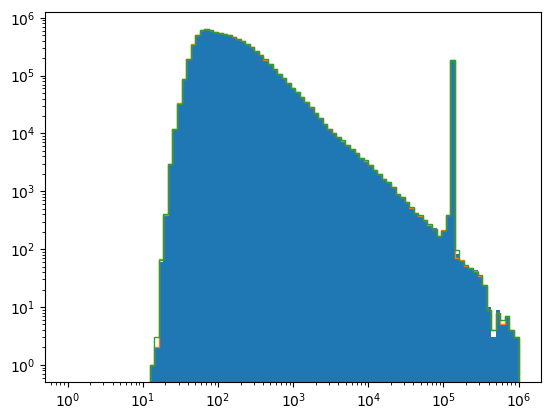

In [40]:
plt.hist(tab_o.col("intensity"), np.logspace(0, 6, 100))
plt.hist(tab_s.col("intensity"), np.logspace(0, 6, 100), histtype="step")
plt.hist(tab.col("intensity"), np.logspace(0, 6, 100), histtype="step")
plt.loglog()
plt.show()

In [ ]:
aa = glob.glob(root_final_results + "*")
dict_general_results = {}
all_values_scaling = []

for i in range(len(aa))[:]:
    a = aa[i]

    with open(a, 'rb') as f:
        _dict_results_ = pickle.load(f)
    
    run = int(a.split("/")[-1].split("_")[-1].split(".")[0])
    run_number = run


    # Getting coordinates of source
    source_coords = SkyCoord.from_name(source_name)
    
    dict_source = {
        "name"   : source_name,
        "coords" : source_coords,
        "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
        "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
    }
    
    # We create a empty dictionary to store all the information needed inside
    dict_dchecks = {}
    for run in [run_number]:
        dict_dchecks[run] = {
            "run_num" : run,
        }
    # Then we add the paths to the files and the datachecks
    dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1)
    dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1, dchecking=True)


    dcheck_zd, dcheck_az = [], []
    dcheck_tstart, dcheck_telapsed = [], []
    
    for srun in range(len(dict_dchecks[run_number]["dchecks"]["srunwise"])):
        tab_dcheck_srun = read_table(dict_dchecks[run_number]["dchecks"]["srunwise"][srun], "/dl1datacheck/cosmics")
        
        # reading the variables
        dcheck_zd.append(90 - np.rad2deg(tab_dcheck_srun["mean_alt_tel"]))
        dcheck_az.append(np.rad2deg(tab_dcheck_srun["mean_az_tel"]))
        
        dcheck_tstart.append(tab_dcheck_srun["dragon_time"])
        dcheck_telapsed.append(tab_dcheck_srun["elapsed_time"])
    
    dcheck_zd = np.array(dcheck_zd)
    dcheck_az = np.array(dcheck_az)
    dcheck_tstart = np.array(dcheck_tstart)
    dcheck_telapsed = np.array(dcheck_telapsed)
    
    dict_dchecks[run_number]["time"] = {
        "tstart"   : dcheck_tstart[0],            # datetime object
        "telapsed" : np.sum(dcheck_telapsed),  # s
        "srunwise" : {
            "telapsed" : dcheck_telapsed,      # s      
        },
    }
    dict_dchecks[run_number]["pointing"] = {
        "zd" : np.mean(dcheck_zd),  # deg
        "az" : np.mean(dcheck_az),  # deg
        "srunwise" : {
            "zd" : dcheck_zd, # deg
            "az" : dcheck_az, # deg
        },
    }
    # then we also select the RFs and MC files looking at the nodes available
    dict_dchecks, dict_nodes = lstpipeline.add_mc_and_rfs_nodes(dict_dchecks, root_rfs, root_mcs, dict_source)


    # Pivot intensity for decorrelation
    ref_intensity = (limits_intensity[0] * limits_intensity[1]) ** 0.5
    
    ########################################################
    # Reading the binning from the datacheck ---------------
    # Opening the corresponding datacheck
    fname_dcheck = dict_dchecks[run_number]["dchecks"]["runwise"]
    tab_dcheck_run = tables.open_file(fname_dcheck)
    
    # Read the binning from the datacheck of the first subrun
    dcheck_intensity_binning = np.array(tab_dcheck_run.root.dl1datacheck.histogram_binning.col("hist_intensity")[0])
    # Calculating the logarithmic center of each bin
    dcheck_intensity_binning_centers = (dcheck_intensity_binning[:-1] * dcheck_intensity_binning[1:]) ** 0.5
    # Calculating the width of each bin
    dcheck_intensity_binning_widths = np.diff(dcheck_intensity_binning)
    tab_dcheck_run.close()
    
    # Mask for the fitting region in the fits
    mask_dcheck_bins_fit = (
        (dcheck_intensity_binning_centers >= limits_intensity[0]) &
        (dcheck_intensity_binning_centers <= limits_intensity[1])
    )

    ##########################################################
    # Reading the histogram from the datacheck ---------------
    # Opening the corresponding datacheck
    dcheck_hist_intensities = []
    for fname_dcheck_srun in dict_dchecks[run_number]["dchecks"]["srunwise"]:
        tab_dcheck_srun = tables.open_file(fname_dcheck_srun)
        dcheck_hist_intensities.append(np.array(tab_dcheck_srun.root.dl1datacheck.cosmics.col("hist_intensity")))
        tab_dcheck_srun.close()
    
    # Converting from counts to rate per intensity unit (non-binning dependent quantity)
    dcheck_rates       = [] # Array of histogram of rates for each subrun
    dcheck_delta_rates = [] # The statistical error
    for srun, dcheck_hist_intensity in enumerate(dcheck_hist_intensities):
    
        effective_time_srun = dict_dchecks[run_number]["time"]["srunwise"]["telapsed"][srun]
        
        dcheck_rates.append(              dcheck_hist_intensity  / effective_time_srun / dcheck_intensity_binning_widths)
    
        dcheck_delta_rates.append(np.sqrt(dcheck_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths)


    corr_factor_p0 = geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
    corr_factor_p1 = geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p1a, p1b, p1c)
    
    # Zenith correction of the reference (putting the reference in the zenith of the determined subrun)
    corr_ref_p0 = ref_p0 / corr_factor_p0
    corr_ref_p1 = ref_p1 - corr_factor_p1


    
    sruns_array = np.sort(list(_dict_results_["statistics"].keys()))
    
    run_num = _dict_results_["run"]
    a1 = np.array([_dict_results_["final_scaling_interpolated"][srun] for srun in sruns_array])
    a2 = np.array([_dict_results_["final_scaling"][srun] for srun in sruns_array])
    delta_a2 = np.array([_dict_results_["delta_final_scaling"][srun] for srun in sruns_array])
    p0 = np.array([_dict_results_["p0"]["original"][srun] for srun in sruns_array])
    pvalues = np.array([_dict_results_["pvalue"]["original"][srun] for srun in sruns_array])
    delta_p0 = np.array([_dict_results_["delta_p0"]["original"][srun] for srun in sruns_array])
    chi2 = _dict_results_["interpolation"]["chi2"]
    pval = _dict_results_["interpolation"]["p_value"] 
    all_values_scaling = [*all_values_scaling, *a2]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    ax1.errorbar(sruns_array, p0, yerr=delta_p0, ls="", marker=".", c="r")
    ax1.axhline(ref_p0, color="k", ls="--", label="dR/dI ref")
    ax1.set_xlabel("Srun number")
    ax1.set_ylabel("dR/dI [ev / s / p.e.]")
    
    ax2.set_ylabel("p-value")
    ax2.plot(sruns_array, pvalues, c="k")
    ax2.set_ylim(-0.1, 1.1)
    
    ax3.plot(sruns_array, a1, c="k", label="Fit")
    colors = plotting.get_colors_multiplot(sruns_array)
    for i in range(len(sruns_array)):
        ax3.errorbar(sruns_array[i], a2[i], yerr=delta_a2[i], ls="", marker=".", c=colors[i])
    ax3.axhline(1, color="k", ls="--", label="No scaling")
    ax3.set_xlabel("Subrun number")
    ax3.set_ylabel("Final scaling")
    
    ax1.set_title(f"Run {run_num}, chi2={chi2:.0f}")
    ax1.legend(loc=1, frameon=False)
    ax3.legend(loc=1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f"plots/profiles_{run_number}.png", bbox_inches="tight", dpi=300)
    plt.show()
    
    
    bins_space = np.linspace(limits_intensity[0] - 100, limits_intensity[1] + 200, 100)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))
    
    colors = plotting.get_colors_multiplot(sruns_array)
    for i in range(len(dcheck_rates)):
        ax.plot(dcheck_intensity_binning_centers, dcheck_rates[i][0], color=colors[i], zorder=np.random.rand())
    
    cmap = plotting.create_cmap_from_colors(plotting.default_colors)
    plotting.plot_colorbar(fig, ax, range(len(dcheck_rates)), cmap=cmap, label="Subrun number")
    
    intensity_sample = np.linspace(limits_intensity[0] / 1.3, limits_intensity[1] * 1.5, 100)
    ax.axvspan(limits_intensity[0], limits_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k")
    
    ax.set_xlabel("Intensity [p.e.]")
    ax.set_ylabel("Rate [events / s / p.e.]")
    ax.loglog()
    ax.set_xlim(1.8e1, 1e4)
    ax.set_ylim(1e-3, 1e2)
    ax.set_title(f"Run {run_num}")
    
    plt.savefig(f"plots/spectrums_{run_number}.png", bbox_inches="tight", dpi=300)
    plt.show()

all_values_scaling = np.array(all_values_scaling)